In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from torchsummary import summary
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2,drop_last =True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:13<00:00, 12656930.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


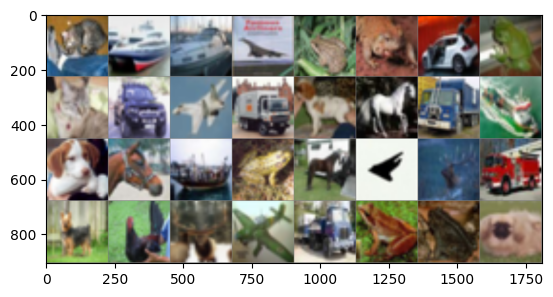

In [4]:
# Show some example images from the CIFAR-10 dataset
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
images, labels = next(iter(test_loader))

# Show the images and their labels
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:', ' '.join(classes[labels[j]] for j in range(32)))


<img src="https://media5.datahacker.rs/2018/11/alexnet_ispravljeno.png" alt="Residual Block" style="width:1000px;height:500px;">


<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-19-16-01-03.png" alt="Residual Block" style="width:1000px;height:500px;">



In [5]:
class ConvBnAct(nn.Module):
    """
    A class to add a block of 3 layers (conv layer, batch-normalization, activation function).

    """
    def __init__(self, in_channels,
                 out_channels,
                 kernel_size=3,
                 conv_kwargs={},
                 Bn=nn.BatchNorm2d,
                 actvtion=nn.SiLU,
                 actvtion_kwargs={}):
        """
        Constructs the three layers.

        Parameters
        ----------
            in_channels : int
                block input channels.
            out_channels : int
                block output channels.
            kernel_size : int (default is 3)
                kernel size for conv layer.
            conv_kwargs : dictionary (default empty dictionary)
                pass customize keyword arguments to conv2d function.
            Bn : nn.module.batchnorm (default is nn.BatchNorm2d)
                Batch normalization layer to Add.
            actvtion : nn.modules.activation (default is SiLU)
                Activation function.
            actvtion_kwargs : dictionary (default empty dictionary)
                pass customize keyword arguments to Activation function.
        """

        super(ConvBnAct, self).__init__()

        self.Conv_BN_Act = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, bias=False, kernel_size=kernel_size, **conv_kwargs),
            Bn(out_channels),
            actvtion(**actvtion_kwargs)
        )
        # bias set to false as we use BN

    def forward(self, x):
        return self.Conv_BN_Act(x)


class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            ConvBnAct(in_channels=3, out_channels=64, conv_kwargs={'padding': 2, 'stride': 4}),
            nn.MaxPool2d(3, stride=2),
            ConvBnAct(in_channels=64, out_channels=192, conv_kwargs={'padding': 2}),
            nn.MaxPool2d(3, stride=2),
            ConvBnAct(in_channels=192, out_channels=384, conv_kwargs={'padding': 1}),
            ConvBnAct(in_channels=384, out_channels=256, conv_kwargs={'padding': 1}),
            ConvBnAct(in_channels=256, out_channels=256, conv_kwargs={'padding': 1}),
            nn.MaxPool2d(3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Ground Truth: cat ship ship airplane frog frog automobile frog cat automobile airplane truck dog horse truck ship dog horse ship frog horse airplane deer truck dog bird deer airplane truck frog frog dog


In [6]:
# Create an instance of the AlexNet model
model = AlexNet(num_classes=10).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [7]:
input_size = (3, 224, 224)
summary(model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 57, 57]           1,728
       BatchNorm2d-2           [-1, 64, 57, 57]             128
              SiLU-3           [-1, 64, 57, 57]               0
         ConvBnAct-4           [-1, 64, 57, 57]               0
         MaxPool2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 192, 30, 30]         110,592
       BatchNorm2d-7          [-1, 192, 30, 30]             384
              SiLU-8          [-1, 192, 30, 30]               0
         ConvBnAct-9          [-1, 192, 30, 30]               0
        MaxPool2d-10          [-1, 192, 14, 14]               0
           Conv2d-11          [-1, 384, 14, 14]         663,552
      BatchNorm2d-12          [-1, 384, 14, 14]             768
             SiLU-13          [-1, 384, 14, 14]               0
        ConvBnAct-14          [-1, 384,

Epoch 1/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 1/10 - Train Loss: 1.4092 - Train Accuracy: 48.38% - Test Loss: 1.0829 - Test Accuracy: 61.46%


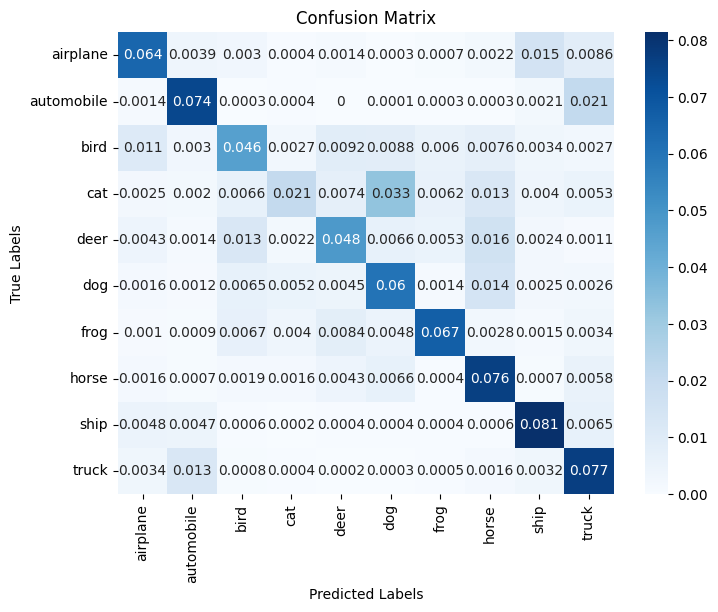

Epoch 2/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 2/10 - Train Loss: 1.0132 - Train Accuracy: 63.65% - Test Loss: 0.8923 - Test Accuracy: 68.76%


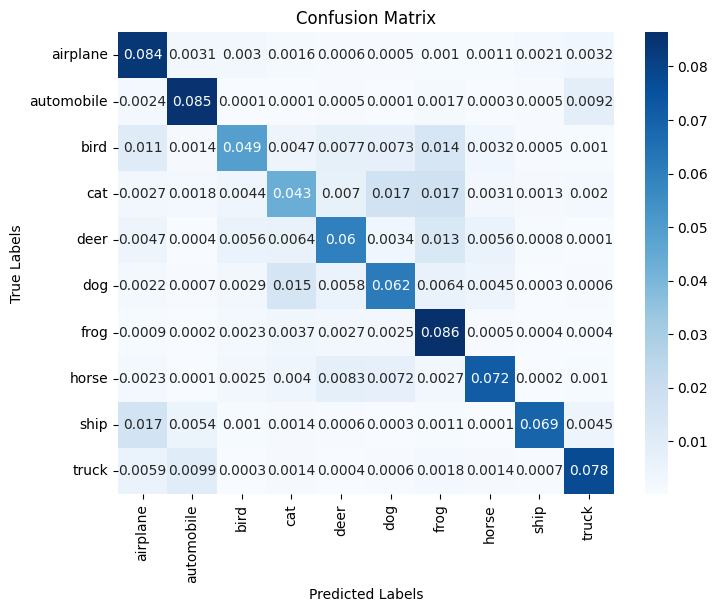

Epoch 3/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 3/10 - Train Loss: 0.8375 - Train Accuracy: 70.28% - Test Loss: 0.8769 - Test Accuracy: 69.57%


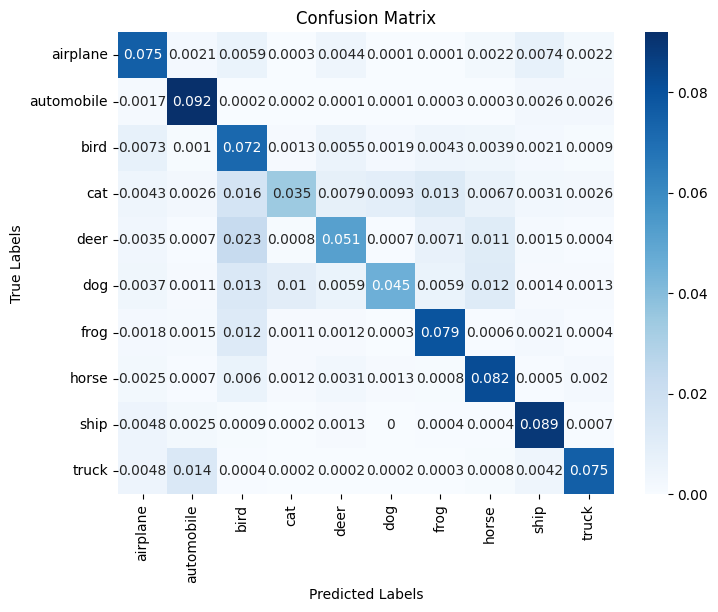

Epoch 4/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 4/10 - Train Loss: 0.7268 - Train Accuracy: 74.26% - Test Loss: 0.8032 - Test Accuracy: 72.89%


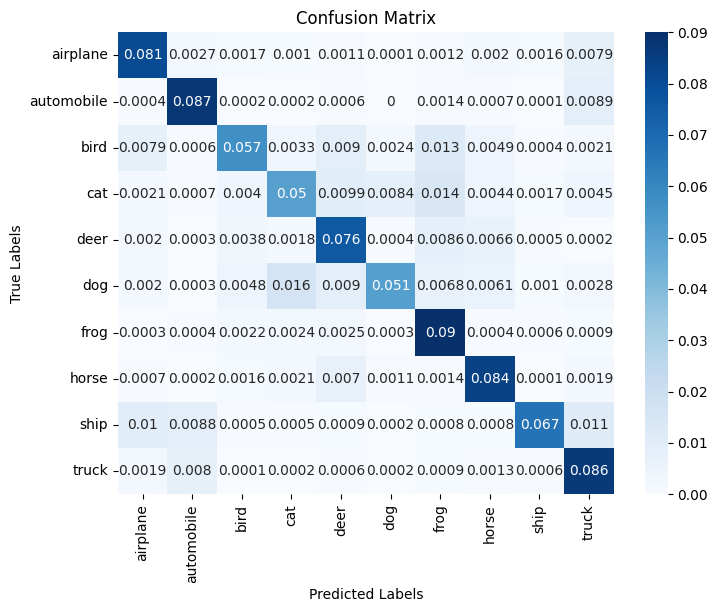

Epoch 5/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 5/10 - Train Loss: 0.6450 - Train Accuracy: 77.40% - Test Loss: 0.6343 - Test Accuracy: 77.80%


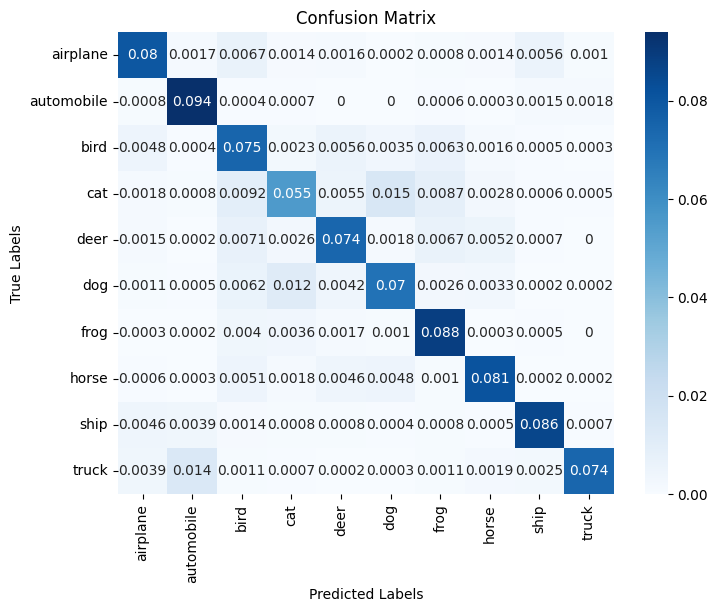

Epoch 6/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 6/10 - Train Loss: 0.5803 - Train Accuracy: 79.71% - Test Loss: 0.6732 - Test Accuracy: 77.01%


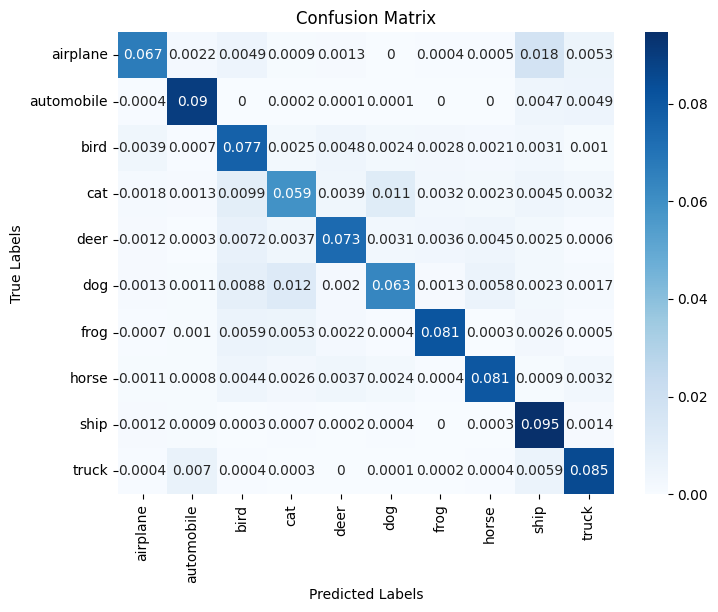

Epoch 7/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 7/10 - Train Loss: 0.5210 - Train Accuracy: 81.66% - Test Loss: 0.5757 - Test Accuracy: 80.22%


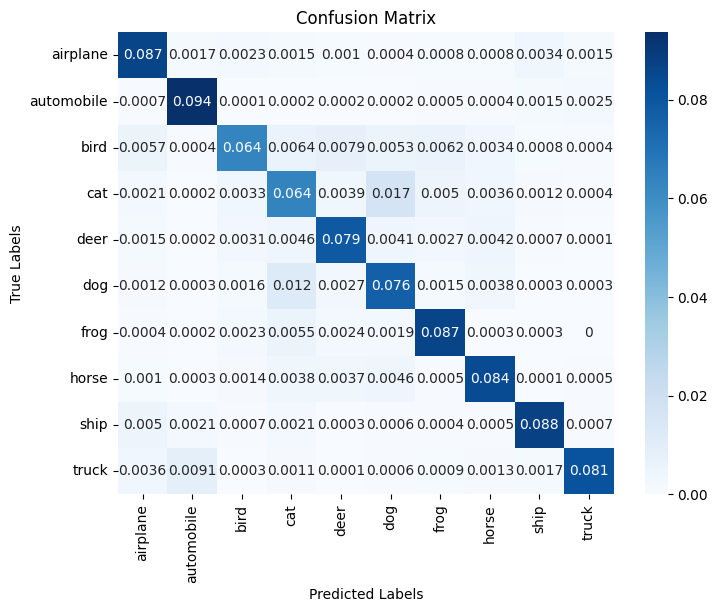

Epoch 8/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 8/10 - Train Loss: 0.4688 - Train Accuracy: 83.42% - Test Loss: 0.5450 - Test Accuracy: 81.58%


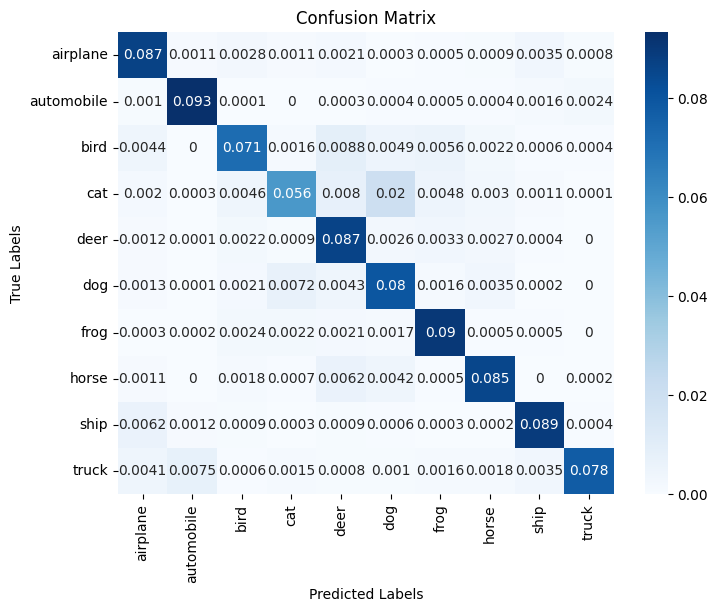

Epoch 9/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 9/10 - Train Loss: 0.4266 - Train Accuracy: 84.87% - Test Loss: 0.5104 - Test Accuracy: 82.35%


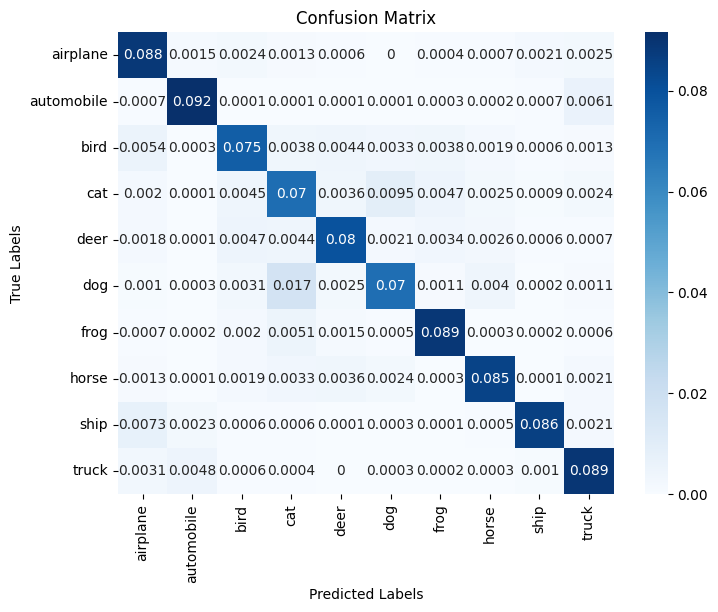

Epoch 10/10:   0%|          | 0/1562 [00:00<?, ?batch/s]

Epoch 10/10 - Train Loss: 0.3851 - Train Accuracy: 86.55% - Test Loss: 0.5726 - Test Accuracy: 80.77%


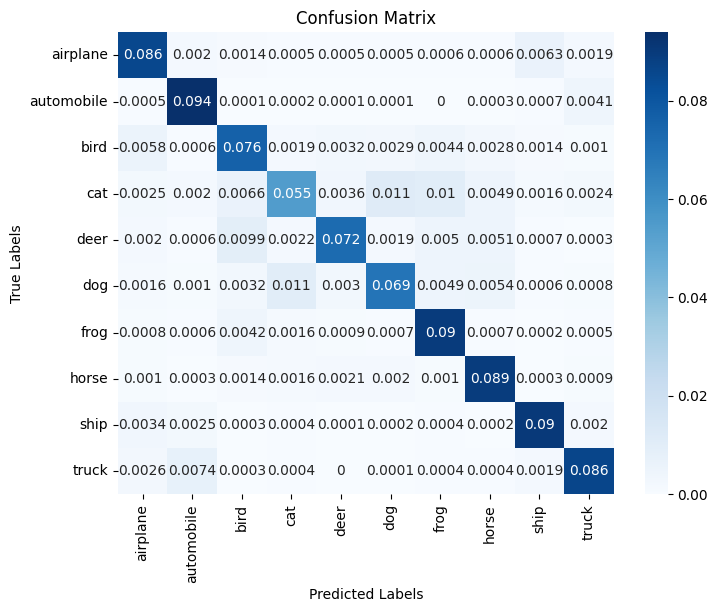

In [8]:
# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update the progress bar
        pbar.update(1)
        pbar.set_postfix({'Loss': loss.item()})

    # Close the progress bar
    pbar.close()

    train_loss /= len(train_loader)
    train_accuracy = 100.0 * correct / total
#------------------------------------------------------------------------------
    # Validation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predicted = []

    all_labels = []


    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predicted.append(predicted)
            all_labels.append(labels)



    # Convert the lists to tensors
    all_predicted = torch.cat(all_predicted).tolist()
    all_labels = torch.cat(all_labels).tolist()

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted ,normalize= 'all')

    # Print training and validation metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
    classes = train_dataset.classes
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

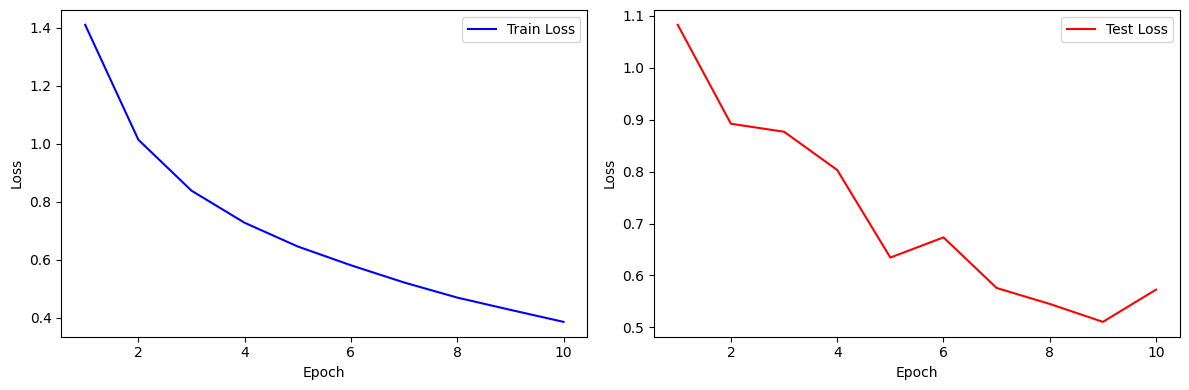

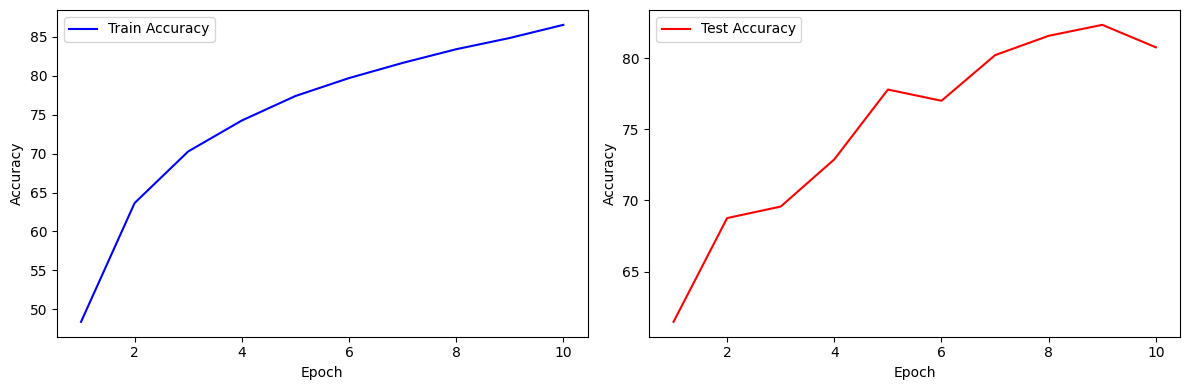

In [9]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

# Plot train accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()